<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/atomgpt_forward_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AtomGPT example: https://pubs.acs.org/doi/10.1021/acs.jpclett.4c01126


# Table of contents

1. Installing [AtomGPT](https://github.com/usnistgov/atomgpt)
2. Train a forward prediction model using AtomGPT
3. Use the model for forward predictions
4. Comapre with [ALIGNN](https://github.com/usnistgov/alignn)

Author: Kamal Choudhary (kamal.choudhary@nist.gov)

Run this block and wait for a few seconds

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:15
🔁 Restarting kernel...


# 1. Installation

In [1]:
%%time
import os
os.chdir('/content')
!rm -rf Software
os.makedirs('/content/Software')
os.chdir('/content/Software')
if not os.path.exists('atomgpt'):
  !rm -rf atomgpt
  !git clone https://github.com/usnistgov/atomgpt.git
  os.chdir('atomgpt')
  ! git checkout dev
  !pip install -qqq -r dev-requirements.txt
  !pip install -q protobuf
  !pip install -q -e .
  !git status


Cloning into 'atomgpt'...
remote: Enumerating objects: 611, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 611 (delta 47), reused 45 (delta 19), pack-reused 500 (from 1)
Receiving objects: 100% (611/611), 66.31 MiB | 48.71 MiB/s, done.
Resolving deltas: 100% (282/282), done.
Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
!pip install -q jarvis_leaderboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.0/259.0 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 6.7 MB/s eta 0:00:00


In [3]:
# Check imports
import alignn
import atomgpt

In [4]:
!jarvis_populate_data.py --benchmark_file AI-SinglePropertyPrediction-exfoliation_energy-dft_3d-test-mae --output_path=Out

benchmark_file AI-SinglePropertyPrediction-exfoliation_energy-dft_3d-test-mae
dataset dft_3d
output_path Out
property exfoliation_energy
method AI
task SinglePropertyPrediction
id_tag jid
out_format poscar
dataset file to be used /usr/local/lib/python3.10/site-packages/jarvis_leaderboard/benchmarks/AI/SinglePropertyPrediction/dft_3d_exfoliation_energy.json.zip
Currently for atomistic datasets only.
https://jarvis-tools.readthedocs.io/en/master/databases.html
Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
100% 40.8M/40.8M [00:03<00:00, 11.2MiB/s]
Loading the zipfile...
Loading completed.
number of training samples 650
number of validation samples 81
number of test samples 81


In [5]:
ls Out/id_prop.csv

Out/id_prop.csv


In [6]:
from jarvis.db.jsonutils import loadjson,dumpjson
dataset_info = loadjson('Out/dataset_info.json')
#print(dataset_info)
n_train = dataset_info['n_train']
n_val = dataset_info['n_val']
n_test = dataset_info['n_test']

In [7]:
# We are using "google/flan-t5-small" because of computational cost, you can also try other models such as "gpt2"
temp_config = {
    "id_prop_path": "Out/id_prop.csv",
    "prefix": "atomgpt_run",
    "model_name": "google/flan-t5-small",
    "batch_size": 5,
    "max_length": 512,
    "num_epochs": 10,
    "latent_dim": 1024,
    "learning_rate": 0.001,
    "test_each_run": True,
    "include_struct": False,
    "pretrained_path": "",
    "seed_val": 42,
    "n_train": n_train,
    "n_val": n_val,
    "n_test": n_test,
    "output_dir": "atomgpt_out",
    "train_ratio": None,
    "val_ratio": 0.1,
    "test_ratio": 0.1,
    "keep_data_order": True,
    "desc_type": "desc_3",
    "convert":True
}
dumpjson(data=temp_config,filename='atomgpt_config.json')

In [8]:
!pip install -q git+https://github.com/usnistgov/jarvis.git@develop

  Preparing metadata (setup.py) ... done


In [9]:
%%time
!atomgpt_forward --config_name atomgpt_config.json

/usr/local/lib/python3.10/site-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ('settings_',)`.
  warnings.warn(
Running AtomGPT prop predictor.
PATH /content/Software/atomgpt/atomgpt_
TrainingPropConfig(id_prop_path='Out/id_prop.csv', prefix='atomgpt_run', model_name='google/flan-t5-small', batch_size=5, max_length=512, num_epochs=20, latent_dim=1024, learning_rate=0.001, test_each_run=True, include_struct=False, pretrained_path='', seed_val=42, n_train=650, n_val=81, n_test=81, output_dir='atomgpt_out', desc_type='desc_3', convert=True, train_ratio=None, val_ratio=0.1, test_ratio=0.1, keep_data_order=True)
100% 812/812 [01:49<00:00,  7.38it/s]
len 812
Using rest of the dataset except the test and val sets.
test_texts: 81
val_texts example: CrAgP2S6 crystallizes in the monoclinic P2/c spacegroup.
test_texts example: Ge5

In [10]:
!ls -altr atomgpt_out/

total 238548
-rw-r--r-- 1 root root       568 Oct  4 14:11 config.json
drwxr-xr-x 8 root root      4096 Oct  4 14:11 ..
-rw-r--r-- 1 root root      2017 Oct  4 14:30 val_results.csv
-rw-r--r-- 1 root root 244240575 Oct  4 14:30 best_model.pt
-rw-r--r-- 1 root root       814 Oct  4 14:30 history.json
-rw-r--r-- 1 root root      2020 Oct  4 14:30 test_results.csv
drwxr-xr-x 2 root root      4096 Oct  4 14:30 .
-rw-r--r-- 1 root root      1995 Oct  4 14:30 test_results_final.csv


The test_results.csv can be upload to JARVIS-Leaderboard

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
# temp was the output directory we specified
df = pd.read_csv('atomgpt_out/test_results.csv')
df

,id,target,predictions
0,JVASP-12119,65.55,71.277
1,JVASP-12181,132.96,82.248
2,JVASP-9690,170.78,90.198
3,JVASP-3636,96.39,94.875
4,JVASP-12148,106.02,88.536
...,...,...,...
76,JVASP-12932,48.54,78.894
77,JVASP-5269,221.48,110.581
78,JVASP-12018,57.38,85.053
79,JVASP-231,79.55,77.186


Text(0, 0.5, 'AI Exfo. energy (meV)')

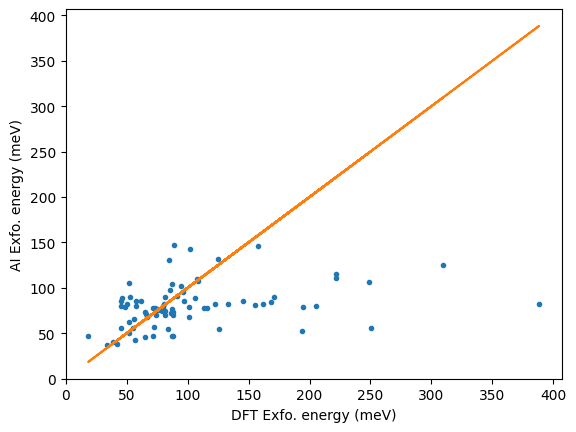

In [13]:
plt.plot(df['target'],df['predictions'],'.')
plt.plot(df['target'],df['target'])
plt.xlabel('DFT Exfo. energy (meV)')
plt.ylabel('AI Exfo. energy (meV)')

In [14]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df['target'],df['predictions'])

37.69862962962963

Inference on a new material

In [ ]:
#Lets load the model first
import transformers, torch, os, json, zipfile
model_name = temp_config['model_name']
output_dir = temp_config['output_dir']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if "t5" in model_name:
    model = transformers.T5ForConditionalGeneration.from_pretrained(
        model_name
    )
else:
    model = transformers.AutoModelForCausalLM.from_pretrained(
        model_name,
        low_cpu_mem_usage=True,
    )

tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": "[PAD]"})
    model.resize_token_embeddings(len(tokenizer))
model.lm_head = torch.nn.Sequential(
    torch.nn.Linear(model.config.hidden_size, temp_config["latent_dim"]),
    torch.nn.Linear(temp_config["latent_dim"], 1),
)
model.load_state_dict(torch.load(output_dir+"/best_model.pt", map_location=device))

In [21]:
# Get description
from jarvis.io.vasp.inputs import Poscar

pos="""C2
1.0
2.1874686952597293 -1.033047e-10 1.2629352933595248
0.7291565647587371 2.062365242524199 1.2629352933595248
3.991386e-10 2.822336e-10 2.525871585336393
C
2
Cartesian
2.55205125 1.80457375 4.4202812499999995
0.36457874999999995 0.25779625 0.63146875
"""
pos="""Si2
1.0
3.3641499856336465 -2.5027128e-09 1.94229273881412
1.121382991333525 3.1717517190189715 1.9422927388141193
-2.5909987e-09 -1.8321133e-09 3.884586486670313
Si
2
Cartesian
3.92483875 2.77528125 6.7980237500000005
0.56069125 0.39646875 0.9711462500000001
"""
atoms=Poscar.from_string(pos).atoms
print(atoms)
desc=atoms.describe()[temp_config['desc_type']]
# desc=atoms.describe()['desc_2']

print(desc)

System
1.0
3.3641499856336465 -2.5027128e-09 1.94229273881412
1.121382991333525 3.1717517190189715 1.9422927388141193
-2.5909987e-09 -1.8321133e-09 3.884586486670313
Si 
2 
direct
0.8750000000000001 0.875 0.875 Si
0.12499999999999999 0.125 0.12500000000000003 Si

Si crystallizes in the cubic Fd-3m spacegroup.


<All keys matched successfully>

In [44]:
max_length=512
input_ids = tokenizer(
    [desc],
    return_tensors="pt",
    max_length=max_length,
    padding="max_length",
    truncation=True,
)['input_ids']


input_ids=input_ids.to(device)
model=model.to(device)

if "t5" in model_name:
    predictions = (
        model(
            input_ids,
            decoder_input_ids=input_ids,
        )
        .logits.squeeze()
        .mean(dim=-1)
    )
else:
    predictions = (
        model(
            input_ids.to(device),
        )
        .logits.squeeze()
        .mean(dim=-1)
    )

predictions = predictions.cpu().detach().numpy().tolist()
print(predictions)



86.45658111572266


For similar ALIGNN training see: https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/alignn_jarvis_leaderboard.ipynb

In [45]:
!conda env export

name: base
channels:
  - conda-forge
dependencies:
  - _libgcc_mutex=0.1=conda_forge
  - _openmp_mutex=4.5=2_gnu
  - archspec=0.2.2=pyhd8ed1ab_0
  - boltons=23.1.1=pyhd8ed1ab_0
  - brotli-python=1.1.0=py310hc6cd4ac_1
  - bzip2=1.0.8=hd590300_5
  - c-ares=1.24.0=hd590300_0
  - ca-certificates=2023.11.17=hbcca054_0
  - cffi=1.16.0=py310h2fee648_0
  - charset-normalizer=3.3.2=pyhd8ed1ab_0
  - colorama=0.4.6=pyhd8ed1ab_0
  - conda=23.11.0=py310hff52083_1
  - conda-libmamba-solver=23.12.0=pyhd8ed1ab_0
  - conda-package-handling=2.2.0=pyh38be061_0
  - conda-package-streaming=0.9.0=pyhd8ed1ab_0
  - distro=1.8.0=pyhd8ed1ab_0
  - fmt=10.1.1=h00ab1b0_1
  - icu=73.2=h59595ed_0
  - jsonpatch=1.33=pyhd8ed1ab_0
  - jsonpointer=2.4=py310hff52083_3
  - keyutils=1.6.1=h166bdaf_0
  - krb5=1.21.2=h659d440_0
  - ld_impl_linux-64=2.40=h41732ed_0
  - libarchive=3.7.2=h2aa1ff5_1
  - libcurl=8.5.0=hca28451_0
  - libedit=3.1.20191231=he28a2e2_2
  - libev=4.33=hd590300_2
  - libffi=3.4.2=h7f98852_5
  - libgcc-n

In [46]:
!pip freeze

absl-py==1.4.0
accelerate==0.31.0
aiohttp==3.9.5
aiosignal==1.3.1
alignn==2024.4.20
annotated-types==0.7.0
archspec @ file:///home/conda/feedstock_root/build_artifacts/archspec_1699370045702/work
ase==3.23.0
async-timeout==4.0.3
-e git+https://github.com/usnistgov/atomgpt.git@d13fd33b0e2609d8770acab35aa2f8786a848615#egg=atomgpt
attrs==23.2.0
autopep8==2.3.1
babel==2.16.0
bitsandbytes==0.43.1
black==24.4.2
boltons @ file:///home/conda/feedstock_root/build_artifacts/boltons_1703154663129/work
Brotli @ file:///home/conda/feedstock_root/build_artifacts/brotli-split_1695989787169/work
certifi==2024.6.2
cffi @ file:///home/conda/feedstock_root/build_artifacts/cffi_1696001684923/work
chardet==3.0.4
charset-normalizer @ file:///home/conda/feedstock_root/build_artifacts/charset-normalizer_1698833585322/work
click==8.1.7
colorama @ file:///home/conda/feedstock_root/build_artifacts/colorama_1666700638685/work
conda @ file:///home/conda/feedstock_root/build_artifacts/conda_1701731572133/work
conda

In [47]:
!conda env export

name: base
channels:
  - conda-forge
dependencies:
  - _libgcc_mutex=0.1=conda_forge
  - _openmp_mutex=4.5=2_gnu
  - archspec=0.2.2=pyhd8ed1ab_0
  - boltons=23.1.1=pyhd8ed1ab_0
  - brotli-python=1.1.0=py310hc6cd4ac_1
  - bzip2=1.0.8=hd590300_5
  - c-ares=1.24.0=hd590300_0
  - ca-certificates=2023.11.17=hbcca054_0
  - cffi=1.16.0=py310h2fee648_0
  - charset-normalizer=3.3.2=pyhd8ed1ab_0
  - colorama=0.4.6=pyhd8ed1ab_0
  - conda=23.11.0=py310hff52083_1
  - conda-libmamba-solver=23.12.0=pyhd8ed1ab_0
  - conda-package-handling=2.2.0=pyh38be061_0
  - conda-package-streaming=0.9.0=pyhd8ed1ab_0
  - distro=1.8.0=pyhd8ed1ab_0
  - fmt=10.1.1=h00ab1b0_1
  - icu=73.2=h59595ed_0
  - jsonpatch=1.33=pyhd8ed1ab_0
  - jsonpointer=2.4=py310hff52083_3
  - keyutils=1.6.1=h166bdaf_0
  - krb5=1.21.2=h659d440_0
  - ld_impl_linux-64=2.40=h41732ed_0
  - libarchive=3.7.2=h2aa1ff5_1
  - libcurl=8.5.0=hca28451_0
  - libedit=3.1.20191231=he28a2e2_2
  - libev=4.33=hd590300_2
  - libffi=3.4.2=h7f98852_5
  - libgcc-n